In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
fashion_mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1,))  
])

fashion_mnist_train_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=True, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_train, shuffle=True
)

fashion_mnist_test_loader = DataLoader(
    datasets.FashionMNIST('/files/', train=False, download=True, transform=fashion_mnist_transform),
    batch_size=batch_size_test, shuffle=True
)

In [4]:
train_loader_pca = copy.copy(fashion_mnist_train_loader)
test_loader_pca = copy.copy(fashion_mnist_test_loader)

train_loader_auto = copy.copy(fashion_mnist_train_loader)
test_loader_auto = copy.copy(fashion_mnist_test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
# Autoencoder
#latent_dim = 100  
autoencoder = Autoencoder2()
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.013473646715283394
Epoch [2/5], Loss: 0.012846113182604313
Epoch [3/5], Loss: 0.01045222394168377
Epoch [4/5], Loss: 0.009305999614298344
Epoch [5/5], Loss: 0.008904551155865192


# Experiment

In [7]:
alpha = 0.1
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [8]:
trainingset = fashion_mnist_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 8

In [9]:

partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]


for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1=time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)
    t2= time.time()


    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in fashion_mnist_test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')


    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,fashion_mnist_test_loader,test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in fashion_mnist_test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(fashion_mnist_test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.282267
Train Epoch: 1 [640/8317 (8%)]	Loss: 2.020690
Train Epoch: 1 [1280/8317 (15%)]	Loss: 1.190142
Train Epoch: 1 [1920/8317 (23%)]	Loss: 1.023785
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.671913
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.670445
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.388119
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.599764
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.327130
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.331075
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.255907
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.390616
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.298205
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.247736
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.172644
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.391423
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.431839
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.209751
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.335788
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.317564
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.8020, Accuracy: 4224/10000 (42%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.217095
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.508872
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.479147
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.322306
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.446247
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.229470
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.124757
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.224761
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.056846
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.206194
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.211231
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.195295
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.195472
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.102539
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.233225
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.233028
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.188251
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.308893
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.269315
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.219595
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1530, Accuracy: 5603/10000 (56%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.450559
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.354786
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.214516
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.324726
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.232805
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.319107
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.201930
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.193466
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.229627
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.160853
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.178077
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.313096
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.197823
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.198044
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.149797
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.207536
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.374236
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.177058
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.255811
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.163132
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8571, Accuracy: 6547/10000 (65%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.141918
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.137658
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.154322
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.177219
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.195452
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.095606
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.358170
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.177719
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.277670
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.088639
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.159632
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.093232
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.097670
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.188524
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.207734
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.171486
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.101289
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.187816
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.144125
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7419, Accuracy: 6943/10000 (69%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.079453
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.058105
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.072251
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.143195
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.089660
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.355439
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.123154
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.181085
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.255029
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.075148
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.181647
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.196814
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.155153
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.128316
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.146680
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.168643
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.092502
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.225892
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.141931
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6573, Accuracy: 7443/10000 (74%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.903202
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.278583
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.188718
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.133841
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.091998
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.160923
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.122951
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.082222
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.179866
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.171310
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.141373
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.080033
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.120331
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.101737
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.202438
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.153055
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.176425
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.110539
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.047075
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6240, Accuracy: 7623/10000 (76%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.000204
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.310154
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.170040
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.059023
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.118705
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.097087
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.067949
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.301977
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.082098
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.324097
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.146637
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.149087
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.308555
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.074403
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.069210
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.192187
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.074779
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.097137
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.117573
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5975, Accuracy: 7750/10000 (78%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.880175
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.135508
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.317429
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.077195
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.067392
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.157756
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.062328
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.242995
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.373310
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.159148
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.158171
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.083047
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.165071
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.155169
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.201788
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.108117
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.103250
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.133742
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.249445
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5905, Accuracy: 7764/10000 (78%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.865569
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.209240
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.126704
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.150550
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.247901
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.033776
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.071596
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.157497
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.293511
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.059170
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.096690
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.107125
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.315772
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.315292
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.105799
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.185440
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.132832
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.196020
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.146193
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7055, Accuracy: 7575/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.297137
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.031749
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.146769
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.058008
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.173669
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.131590
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021733
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.262797
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.104386
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.291305
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.039458
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.094423
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.083196
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.064421
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.173941
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.125575
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.143529
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.218493
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.098178
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7588, Accuracy: 7495/10000 (75%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.410479
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.234466
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.136373
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.198882
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.066579
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.100432
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.033399
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.142047
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.142693
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.059464
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.125945
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.046347
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.043285
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.042472
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.044336
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.032946
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.140136
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.075716
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.066489
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7341, Accuracy: 7543/10000 (75%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.385739
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.106832
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.066961
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.092289
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.081009
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.063854
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.057127
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.073725
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.061098
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.107588
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.035626
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.032181
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.163451
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.097841
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.159175
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.125176
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.060167
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.039810
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.158253
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7448, Accuracy: 7519/10000 (75%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.354000
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.177109
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.078521
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.107289
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.201395
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.087741
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.053173
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.086816
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.065638
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.112502
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.037601
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.063453
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.104184
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.081681
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.107790
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.013398
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.034402
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.112160
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008941
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7396, Accuracy: 7484/10000 (75%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.231841
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.034741
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.114145
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.168646
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.136237
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.084227
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.037222
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.185793
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.103118
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.104785
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.145819
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.041419
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.026575
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018572
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021946
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.129905
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.052184
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.091260
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.154564
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6751, Accuracy: 7723/10000 (77%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.324486
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.033047
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.043630
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.061881
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.059419
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.104588
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.057662
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.052872
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.112231
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.093908
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.034602
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.110932
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.183031
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.057675
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.190912
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.066523
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.062177
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.058670
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.100192
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7401, Accuracy: 7593/10000 (76%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.361748
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.121224
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.104048
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.105260
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.034110
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.062876
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.032855
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.030027
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.224848
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.029436
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.054370
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.095452
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.066902
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.136507
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.037100
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.015380
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.229121
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.098606
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.024001
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7656, Accuracy: 7553/10000 (76%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.435062
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.167757
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.041735
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.027046
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.089697
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.108313
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.053049
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.202674
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.058982
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.047677
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.016677
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.311270
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.027918
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.089493
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.061138
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.032296
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.058812
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.019366
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.069952
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6802, Accuracy: 7568/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.751031
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.063125
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.048897
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.114571
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.144481
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.023141
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.024185
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.073698
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.125272
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.044147
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.036624
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.014697
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.199405
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031874
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.107273
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.106535
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.085848
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.044004
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.061188
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6481, Accuracy: 7716/10000 (77%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.599472
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.112315
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.017984
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.310193
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.035522
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.079631
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.019565
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.035196
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.097074
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.081320
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.035424
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007355
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.117495
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.134384
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.066435
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.102379
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.039427
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.025763
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008563
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6056, Accuracy: 7885/10000 (79%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.890744
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.032361
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.081658
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.087836
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.089903
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.051053
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.086978
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.075235
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.037421
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.064033
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008098
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.043943
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.040854
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.032823
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.025577
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.194600
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.100399
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.056287
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.045436
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6064, Accuracy: 7867/10000 (79%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.524628
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.062939
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.141501
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.071857
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.033611
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.104921
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.027439
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.009489
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.043725
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.050553
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.010753
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.068808
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.082054
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.065992
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.132918
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.038440
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.043115
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014614
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.072162
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6226, Accuracy: 7836/10000 (78%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.587162
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.052715
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.126362
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.068922
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.022019
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.069344
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.092721
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.066812
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.041189
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.059178
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.075440
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.024146
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.090378
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.040569
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.083077
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.059478
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.044479
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.103104
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.086976
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6128, Accuracy: 7859/10000 (79%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.709502
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.100021
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.044430
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.023188
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.049937
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009416
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.054561
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.088149
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.038752
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.067129
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.213023
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.064738
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.162838
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.133283
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.051993
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.067915
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.076965
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.039807
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.026388
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5904, Accuracy: 7974/10000 (80%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.622570
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.142490
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.012532
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.021223
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.106623
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.039897
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.048456
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017695
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.053518
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.020060
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.034629
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.065717
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.050231
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.082717
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.037102
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.031274
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.042575
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.035930
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.056303
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5894, Accuracy: 7978/10000 (80%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.032536
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.081422
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.055770
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.147248
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.160985
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.046869
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.042486
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.157999
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.033610
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.015633
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.043110
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.095097
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.038534
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.044389
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.008324
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.034486
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.027015
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.032182
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.028701
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5346, Accuracy: 8135/10000 (81%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.351098
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.028778
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.128214
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.139271
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.051046
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.020169
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.072850
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.121322
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.105365
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.042082
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012564
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.040785
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.038862
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.014608
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.028318
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.132755
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.029722
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.037662
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.009454
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5720, Accuracy: 8002/10000 (80%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.410229
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.082621
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.024936
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.054779
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.130022
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.206122
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.056248
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.057949
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.024195
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.057355
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.152034
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.028411
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.022268
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.055830
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021149
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.021408
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.010531
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.009409
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.014762
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5519, Accuracy: 8085/10000 (81%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.319651
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.042860
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.048072
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.225494
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.076875
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.012652
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.074655
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.046297
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.154607
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.006630
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008047
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.203959
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.046719
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.033762
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.052112
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.056440
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.015944
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.036181
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.018547
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5512, Accuracy: 8091/10000 (81%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.420467
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.053018
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.099589
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.016739
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.038497
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.040449
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.118007
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.025798
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.030482
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.042236
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.074953
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.070259
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.193333
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031337
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.030761
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.070155
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016661
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.040560
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.053104
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5448, Accuracy: 8121/10000 (81%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.516930
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.027759
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.011955
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.045993
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.018670
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.110525
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.096002
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.011308
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.098357
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.008684
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.205033
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.066588
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.039638
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.015538
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.129378
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.007853
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.025217
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.074300
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.029302
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5445, Accuracy: 8126/10000 (81%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.388965
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.082239
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.043853
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.075823
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.018785
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.082865
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.152218
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.044959
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.009684
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.123891
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.030769
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.075586
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.078859
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.091306
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.022293
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.012919
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.101257
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.040652
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.028480
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5755, Accuracy: 8043/10000 (80%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.544706
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.067069
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.024697
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.106399
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.123900
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.045868
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.047987
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.009998
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.067432
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.076447
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.016886
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006873
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.087311
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.086350
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.032650
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.020927
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.088025
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.043245
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.020052
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5533, Accuracy: 8115/10000 (81%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.426640
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.052375
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019606
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.009841
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.058017
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.065618
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.047358
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.027667
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.011028
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.036538
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.088055
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.064443
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.080117
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.057582
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.093973
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.063095
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.100602
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.034768
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.021351
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5214, Accuracy: 8190/10000 (82%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.804606
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.053670
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.012828
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.011355
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.005198
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.055655
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.028860
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.030757
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.133364
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.037104
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.057097
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.060161
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.010279
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.022544
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.014351
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.059701
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.045656
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.017266
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.031729
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4970, Accuracy: 8291/10000 (83%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.424363
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.089124
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.051409
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.017620
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.012809
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.034729
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.028305
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.084115
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.027130
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.066925
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.066386
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007745
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.083051
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.046602
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.093728
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.031193
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.026900
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.021077
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.016200
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5026, Accuracy: 8267/10000 (83%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.419757
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.067485
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.042540
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.072637
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.080007
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.205182
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.045620
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.062809
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.060259
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.064468
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.032040
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.036303
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.023355
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.020155
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.088148
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.092543
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.108073
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.120193
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.077880
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4873, Accuracy: 8326/10000 (83%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.806369
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.281937
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.035081
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.187105
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.039766
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.101321
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.080706
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.048403
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.109034
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.144927
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.037164
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.063055
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.040219
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.102072
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.042192
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.025668
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.033777
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.017986
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.064491
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5043, Accuracy: 8282/10000 (83%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.508736
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.028544
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.076620
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.051939
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.035482
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.106437
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.033984
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.007582
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.029701
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.032090
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.078525
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007105
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.063733
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018647
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.081401
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.050627
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.144805
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.016070
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.051437
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4844, Accuracy: 8355/10000 (84%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.789446
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.051268
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.011063
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.051849
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.043373
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.010818
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.045129
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.027524
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.032279
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.090211
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.019903
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.071717
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006339
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.079092
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.051746
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.014661
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.008569
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.054741
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.030917
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4970, Accuracy: 8307/10000 (83%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.801750
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.125480
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.033147
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.083205
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.053126
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.042000
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.124384
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.107035
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.132202
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.117486
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.040887
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.027423
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.089646
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008470
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.068647
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.004293
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.068464
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.030573
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.146548
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4680, Accuracy: 8422/10000 (84%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.633622
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.072794
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.063136
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012622
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.037774
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.023410
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.020077
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.044110
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.076545
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.108408
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.057378
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.076505
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.063015
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.086298
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.045349
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.056005
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.019746
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.059723
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.019093
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4535, Accuracy: 8457/10000 (85%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.681057
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.035081
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.079181
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.120808
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.186730
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.059247
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.024651
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.111082
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.012931
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.025048
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.056716
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.100396
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004460
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.169216
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.020850
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.016597
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.171700
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.010282
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.100909
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4528, Accuracy: 8459/10000 (85%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.674246
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.070818
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.014211
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.105797
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.133232
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.075206
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.051610
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.028047
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.031038
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.091105
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.073431
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.047514
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.045377
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.021993
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.066395
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.081397
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.189120
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.039949
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.076462
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4462, Accuracy: 8482/10000 (85%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.711928
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.087093
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.073105
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.189306
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.096068
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.133862
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.101579
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.113846
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.024560
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.097810
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.040675
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.097648
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.027208
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.114113
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.050426
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.030103
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.099395
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.035063
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.016660
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4446, Accuracy: 8490/10000 (85%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.582995
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.022520
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.043312
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.103582
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.062479
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.023405
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.036202
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.013681
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.031917
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.017397
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.015690
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.113959
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.156845
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.004795
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.015971
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.029045
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.064658
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.054499
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.071584
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4388, Accuracy: 8510/10000 (85%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.514626
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.034101
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.083212
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.057990
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.012908
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.042599
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.077766
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.016042
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.060848
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.038680
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.023571
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.045779
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.045965
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.060081
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.005430
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.025913
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007226
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.088822
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.058161
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4561, Accuracy: 8473/10000 (85%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.513943
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.092415
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.095119
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.050170
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.020763
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.067380
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.042974
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004205
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.180874
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.053106
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.030397
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.046145
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.060808
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.091276
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.020855
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.021386
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.057605
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.102338
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.025108
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4425, Accuracy: 8485/10000 (85%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.475448
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.163675
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.033934
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.008135
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.048961
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.058909
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.078316
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.065888
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.100927
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005439
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.134200
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.072147
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.027574
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.026754
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.026792
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.105107
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.027789
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012932
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.091635
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4465, Accuracy: 8492/10000 (85%)



In [10]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5905427734375], 'accuracy': [77.64], 'precision': [0.8078560119407394], 'recall': [0.7764], 'f1': [0.776268108197845], 'trainingTime': [362.01560497283936]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.705538330078125, 0.758801611328125, 0.7340972229003906, 0.7448471618652344, 0.7396003845214844, 0.6750932922363281, 0.7401138488769531, 0.7655611450195312], 'accuracy': [75.75, 74.95, 75.43, 75.19, 74.84, 77.23, 75.93, 75.53], 'precision': [0.8013989926660031, 0.8020803343044134, 0.8043194850413109, 0.8072488019452827, 0.8007664646402759, 0.8047683357586513, 0.8050339351931148, 0.8044749566451304], 'recall': [0.7575000000000001, 0.7495, 0.7543, 0.7519, 0.7484, 0.7723, 0.7593, 0.7553], 'f1': [0.7357977431279717, 0.7248911242638625, 0.7320162738083882, 0.7324537046828631, 0.7284934070406678, 0.7588809356920979, 0.740352036683624, 0.7348586660906824], 'trainingTime': [72.573592

## PCA

In [11]:
trainingset_pca = train_loader_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [12]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = []
local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))


rounds_pca = 8
for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1=time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    t2= time.time()

    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))


    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        t2= time.time()
    
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.253684
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.942258
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.781276
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.393122
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.385566
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.312025
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.069612
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.331520
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.304343
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.490031
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.095012
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.278150
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.213284
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.267389
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.131109
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.248044
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.201722
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.312433
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.432740
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.314599
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.0467, Accuracy: 4869/10000 (49%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.787782
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.362276
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.174281
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.297057
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.179238
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.220691
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.128560
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.230299
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.127801
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.231476
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.149508
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.118783
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.085378
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.240868
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.099757
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.112992
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.047147
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.144911
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.172487
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.210139
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6719, Accuracy: 6602/10000 (66%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.128261
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.241469
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.213610
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.143369
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.300678
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.112848
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.287694
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.195603
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.180633
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.153796
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.104463
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.120163
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.094922
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.084240
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.053309
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.167282
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.098054
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.214827
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.300312
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.090668
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5221, Accuracy: 6796/10000 (68%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.058391
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.081872
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.120513
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.118025
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.237539
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.100575
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.130772
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.163934
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.044818
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.279701
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.193669
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.044768
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.093045
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.062155
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.030764
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.178253
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.115209
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.130848
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.152732
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4617, Accuracy: 6825/10000 (68%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.826868
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.398209
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.175013
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.040660
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.087319
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.231542
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.052525
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.093348
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.275897
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.100126
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.178971
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.099265
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.176755
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.072412
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.167519
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.159339
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.136832
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.179070
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.185307
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4207, Accuracy: 6931/10000 (69%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.652357
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.161376
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.185607
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.074475
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.161136
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.064596
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.066227
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.160719
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.332863
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.034384
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.030823
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.170245
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.098174
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.093549
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.152368
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.139409
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.180926
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.098134
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.133968
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3974, Accuracy: 6942/10000 (69%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.490192
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.108665
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.066133
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.088370
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.121683
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.102144
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.203828
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.070236
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.046842
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.296871
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.036670
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.239294
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.112237
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.093681
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.066623
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.030257
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.064726
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.245929
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.141118
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3774, Accuracy: 6929/10000 (69%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.549003
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.139098
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.147469
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.197117
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.079080
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.070775
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.124132
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.118314
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.071433
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.072887
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.025554
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.092890
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.139801
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.140593
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.158099
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.043963
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.036432
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.101028
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.113236
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3584, Accuracy: 6932/10000 (69%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.628614
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.115393
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.125746
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.067765
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.052598
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.105761
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.269469
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.101843
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.087359
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.078728
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.018280
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.045837
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.056361
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.145684
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.025736
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.150712
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.129282
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.043784
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.076623
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3398, Accuracy: 6593/10000 (66%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.317536
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.063333
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.307234
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.198710
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.060632
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.139340
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010428
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.025492
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.060077
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.143557
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.044435
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.097146
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013320
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.124732
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.235105
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.030735
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.080233
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.044378
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.133815
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3275, Accuracy: 6587/10000 (66%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.244764
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.026789
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.242429
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.020437
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.105658
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.056265
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.069236
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.139942
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.085857
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.149141
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.139526
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.088898
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.032871
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.103760
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.064218
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.066062
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.033376
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.049554
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.109661
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3093, Accuracy: 6506/10000 (65%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.429174
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.040478
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.094428
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.189915
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.085019
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.037370
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.062440
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.051347
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.037794
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.107131
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.047811
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.067070
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.099118
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.126498
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.034752
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.021333
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.109274
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.034780
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.035691
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3009, Accuracy: 6297/10000 (63%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.257758
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.110508
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.041336
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.034983
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.091598
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.023034
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.013891
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.031912
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.125315
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.080063
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.025477
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.100188
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.073693
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.039518
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.058930
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.021869
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.050020
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.078208
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.023204
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2927, Accuracy: 6312/10000 (63%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.220063
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.105058
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.046737
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.009846
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.141104
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.055728
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.019464
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.048046
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.129710
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.017155
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008168
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.036451
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.045939
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.061168
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.009973
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.033961
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.022719
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.028751
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.048458
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2810, Accuracy: 6244/10000 (62%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.401885
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.081653
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.045921
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.023776
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.105040
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.045329
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.070014
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.014955
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.082848
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.056377
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.073159
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.049018
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.065639
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.027425
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.096871
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.014546
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.031768
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.046275
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.006625
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2643, Accuracy: 6193/10000 (62%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.230453
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.073060
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.058346
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.041196
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.032457
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.043718
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.047549
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.018078
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.075858
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.070604
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.017182
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.065974
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.033111
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031982
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.144847
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.019210
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.023954
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.018982
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.134704
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2902, Accuracy: 5760/10000 (58%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.289456
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.076614
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.051510
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.027513
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.061568
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.032814
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.045508
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.020471
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.040524
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.017448
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.029735
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.010284
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.050568
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.015621
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.012658
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.018995
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.030453
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.088191
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.007432
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2610, Accuracy: 6735/10000 (67%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.581143
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.023662
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019911
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019729
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.077866
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.012797
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.096175
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.076831
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.136378
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.127005
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.034799
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.020929
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.025895
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.019286
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.015114
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.063077
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.017187
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012407
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.084341
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2301, Accuracy: 6788/10000 (68%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.442125
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.042304
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.020346
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.097394
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.031223
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009557
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021228
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.192533
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.054121
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.043266
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.038095
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.015941
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005939
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.014099
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.036236
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.004286
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.044111
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.027698
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.048173
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2249, Accuracy: 6562/10000 (66%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.658600
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.046766
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.070105
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022348
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.100158
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.059365
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.014602
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.069419
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.017228
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.084674
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.037039
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.025339
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.030435
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.057974
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011469
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.012450
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.017469
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.084262
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.016593
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2053, Accuracy: 6660/10000 (67%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.458780
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.065049
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.089051
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.034342
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.072601
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.039728
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010089
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.027721
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.010038
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.047378
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.096300
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.066031
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.048106
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.013190
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.031291
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.036011
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.024244
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.060006
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.039812
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1931, Accuracy: 6677/10000 (67%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.564209
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.013531
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.065669
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.136585
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.033643
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.040083
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009656
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.035584
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.010868
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.016264
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.052957
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.040014
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.099488
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.063721
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.043379
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.028946
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.033761
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.020814
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.022018
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2019, Accuracy: 6522/10000 (65%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.307282
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.033008
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.004694
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.026111
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.014035
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.041858
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021657
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.021481
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.055307
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.048358
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.069230
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.025609
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.103693
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.037758
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.020810
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008658
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.038944
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.013567
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.009601
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1889, Accuracy: 6551/10000 (66%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.443444
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.079193
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.015982
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.231858
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.059213
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005615
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.019994
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017063
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.038185
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.026269
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.071538
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.027238
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.026093
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.048537
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.025720
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.010834
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003559
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012866
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.046620
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1798, Accuracy: 6569/10000 (66%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.361570
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.083410
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.027641
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.091870
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.043578
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.011657
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.027625
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.099497
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.009737
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.036842
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.014625
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.032910
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.019744
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.034000
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.017553
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.059456
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006981
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.028023
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.059187
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1698, Accuracy: 6504/10000 (65%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.369222
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.052687
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.101351
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.013669
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.053591
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.061676
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.065191
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.008247
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.014617
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.070165
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005308
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.168487
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.063637
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018952
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.032677
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008054
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.011090
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.044966
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.040132
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1596, Accuracy: 6513/10000 (65%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.314203
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.029339
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019715
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.042721
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.056332
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.007224
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.023782
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.036243
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.050124
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011207
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.043702
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.042012
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.044048
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.044828
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.125624
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.028781
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.136760
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.032241
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.036729
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1559, Accuracy: 6540/10000 (65%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.210200
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.013214
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.011490
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.035504
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.021006
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.041573
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.013993
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.067974
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.035833
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.022723
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012737
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.062416
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009268
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.023334
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.048937
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.036690
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.024101
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.080451
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.014247
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1466, Accuracy: 6581/10000 (66%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.563717
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.040598
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.215413
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.028128
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.045219
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.008576
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.008153
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.020335
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.040607
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.071318
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.084846
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.066735
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.023616
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017903
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.057766
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009786
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003728
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.017411
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.021766
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1361, Accuracy: 6569/10000 (66%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.472670
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.085746
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.008951
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.028529
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.014939
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.105163
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.053059
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.031164
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.035715
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.073336
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012692
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.018581
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.029880
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018174
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007344
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.044638
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016878
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014515
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.011534
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1282, Accuracy: 6593/10000 (66%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.334861
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.012824
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.064883
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.094268
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.104456
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.030938
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.031572
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.022492
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.119412
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005156
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.014074
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006314
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.031117
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.036250
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.020432
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.022059
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006119
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.026078
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008539
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1334, Accuracy: 6462/10000 (65%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.373389
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.034334
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.015785
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022331
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.050317
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.019151
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009093
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.014732
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.071812
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.048375
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.021363
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.113926
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.010353
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.007278
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.055685
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.019670
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016843
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001654
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.065871
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1180, Accuracy: 6542/10000 (65%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.181649
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.056937
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.046486
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.073567
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.026632
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.089804
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.107262
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.033468
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.024924
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.022700
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.038089
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.035821
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.023216
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.015740
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.006808
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.062264
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.011050
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.047383
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.078391
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1011, Accuracy: 6747/10000 (67%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.682820
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.072794
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.077698
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.068275
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.017153
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.037542
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.048070
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.088547
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.075546
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.022423
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003618
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.011925
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.021388
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.106073
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.015793
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002217
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.014334
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.070369
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.025290
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0870, Accuracy: 6890/10000 (69%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.643807
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.008695
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.024420
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.028160
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.076418
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.012581
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.106931
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.089129
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.029704
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.022230
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003433
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.043158
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.080758
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.028305
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001673
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.026858
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001671
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014442
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.009014
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0799, Accuracy: 6879/10000 (69%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.877989
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.162645
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.029194
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.092018
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.015932
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.076246
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.032945
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.038343
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.040107
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.018001
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.019745
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009304
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.106414
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.118629
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.015604
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.007664
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016571
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.039233
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.016163
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0783, Accuracy: 6833/10000 (68%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.568838
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.164016
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.020345
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.047518
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.127742
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.045392
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021765
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017166
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.102288
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.089549
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.009495
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.102788
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.007447
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.019107
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011122
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008372
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.056160
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.007485
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.026923
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0726, Accuracy: 6930/10000 (69%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.683396
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.189442
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.065120
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022666
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.032522
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.022361
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.070821
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.049545
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.069038
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002823
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.021357
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.081004
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.011381
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.065545
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021314
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.015661
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.058026
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.015177
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.010006
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0608, Accuracy: 6922/10000 (69%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.375708
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.087501
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.034420
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.037002
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.179566
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.007439
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.096617
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.099775
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.010761
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.064518
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.061090
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.040203
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.023504
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.014482
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.009636
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.041792
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.028927
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.021972
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008577
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0538, Accuracy: 6919/10000 (69%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.476140
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.039157
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.036195
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.010554
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.012740
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.027102
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.022578
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.009469
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004007
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.012332
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.017948
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.016711
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.014449
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.024064
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.024599
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002493
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002007
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.010131
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.005239
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0492, Accuracy: 6883/10000 (69%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.005061
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.027385
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.001695
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.195608
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.005204
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.013965
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.037125
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.061376
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004225
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.038220
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.071945
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.094822
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.088296
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017354
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.016669
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.056374
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.015202
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.038982
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.056984
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0236, Accuracy: 7233/10000 (72%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.627231
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.044472
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.055720
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.089572
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.052020
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006512
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.059062
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.080966
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.045645
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002685
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.058536
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.125256
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.007888
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008076
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.073692
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.013982
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004449
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.049954
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008721
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0263, Accuracy: 7206/10000 (72%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.512863
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.022838
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.034145
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.013907
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.013041
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.020134
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.018318
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.126855
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001875
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011566
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012893
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.018395
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.056900
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.006449
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.013377
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.056274
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003945
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.068031
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.015305
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0163, Accuracy: 7244/10000 (72%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.750898
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.022294
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.018343
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022240
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.023027
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.061652
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.001191
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.076690
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.063141
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.085092
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.021969
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006071
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.011477
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.063782
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.030673
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.043571
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.018059
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.015486
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.159418
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0173, Accuracy: 7210/10000 (72%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.625441
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.034805
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.027998
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.015171
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006666
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.031320
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.018668
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.010279
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.037761
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.097230
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.059255
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.064033
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.033605
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008965
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.027185
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.021982
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.008426
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.038250
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.090331
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0096, Accuracy: 7252/10000 (73%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.604270
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.048830
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.093108
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.034252
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.042663
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.028112
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009757
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.061476
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.040142
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.050517
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.068545
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.027486
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009923
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031428
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.029632
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008226
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.052770
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.000505
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.033845
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0053, Accuracy: 7254/10000 (73%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.793537
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.023381
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.007015
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005585
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.010701
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.061604
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.044905
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.011031
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003363
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.072521
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.029929
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.059666
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.057151
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.020649
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002488
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.047446
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.065502
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.020057
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.015213
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0042, Accuracy: 7234/10000 (72%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.388551
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.083201
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.013141
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.014097
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.067062
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009704
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.024941
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.071847
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.071592
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.084481
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.018970
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.073169
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004865
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.059102
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.013134
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.004908
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.011825
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.070253
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.128132
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9954, Accuracy: 7281/10000 (73%)



In [12]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5905427734375], 'accuracy': [77.64], 'precision': [0.8078560119407394], 'recall': [0.7764], 'f1': [0.776268108197845], 'trainingTime': [362.01560497283936]}}, 'pca': {'NoCluster': {'losses': [1.3583802612304687], 'accuracy': [69.32], 'precision': [0.7653299602973461], 'recall': [0.6931999999999999], 'f1': [0.6701533425557449], 'trainingTime': [51.11389756202698]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.705538330078125, 0.758801611328125, 0.7340972229003906, 0.7448471618652344, 0.7396003845214844, 0.6750932922363281, 0.7401138488769531, 0.7655611450195312], 'accuracy': [75.75, 74.95, 75.43, 75.19, 74.84, 77.23, 75.93, 75.53], 'precision': [0.8013989926660031, 0.8020803343044134, 0.8043194850413109, 0.8072488019452827, 0.8007664646402759, 0.8047683357586513, 0.8050339351931148, 0.8044749566451304], 'recall': [0.7575000000000001, 0.7495, 0.7543, 0.7519, 0.7484, 0.7723, 0.7593, 0.75

In [ ]:
""" 
results= {'classic': {'NoCluster': {'losses': [0.5905427734375], 'accuracy': [77.64], 'precision': [0.8078560119407394], 'recall': [0.7764], 'f1': [0.776268108197845], 'trainingTime': [362.01560497283936]}}, 'pca': {'NoCluster': {'losses': [1.3583802612304687], 'accuracy': [69.32], 'precision': [0.7653299602973461], 'recall': [0.6931999999999999], 'f1': [0.6701533425557449], 'trainingTime': [51.11389756202698]}}, 'autoencoder': {}}
clusteredResults = {'classic': {2: {'losses': [0.705538330078125, 0.758801611328125, 0.7340972229003906, 0.7448471618652344, 0.7396003845214844, 0.6750932922363281, 0.7401138488769531, 0.7655611450195312], 'accuracy': [75.75, 74.95, 75.43, 75.19, 74.84, 77.23, 75.93, 75.53], 'precision': [0.8013989926660031, 0.8020803343044134, 0.8043194850413109, 0.8072488019452827, 0.8007664646402759, 0.8047683357586513, 0.8050339351931148, 0.8044749566451304], 'recall': [0.7575000000000001, 0.7495, 0.7543, 0.7519, 0.7484, 0.7723, 0.7593, 0.7553], 'f1': [0.7357977431279717, 0.7248911242638625, 0.7320162738083882, 0.7324537046828631, 0.7284934070406678, 0.7588809356920979, 0.740352036683624, 0.7348586660906824], 'trainingTime': [72.57359290122986, 69.61292576789856, 77.11956739425659, 74.6767361164093, 78.27727389335632, 71.79576539993286, 79.21712517738342, 81.79148149490356]}, 4: {'losses': [0.6801788208007813, 0.6481188354492188, 0.6056239440917969, 0.6064419006347657, 0.6225898254394531, 0.6128303955078125, 0.5904341644287109, 0.5893617309570313], 'accuracy': [75.68, 77.16, 78.85, 78.67, 78.36, 78.59, 79.74, 79.78], 'precision': [0.7978467874491495, 0.8124620914804845, 0.8147936302913455, 0.8168447829519107, 0.8215291512695992, 0.8204264296104004, 0.823411817067198, 0.8235380469375488], 'recall': [0.7568, 0.7716000000000001, 0.7885000000000001, 0.7867, 0.7835999999999999, 0.7859, 0.7974, 0.7978], 'f1': [0.7518844224209065, 0.7697296367304175, 0.7879017184797409, 0.7866059987796687, 0.7834455030912677, 0.7857581974755015, 0.7975709315146748, 0.7979056421100259], 'trainingTime': [162.60828113555908, 135.10689759254456, 145.41593265533447, 139.56093502044678, 142.5864062309265, 144.65416836738586, 142.36847352981567, 133.0431044101715]}, 6: {'losses': [0.5346215637207031, 0.57199755859375, 0.5519169067382812, 0.5512250762939453, 0.5448290771484375, 0.5445326782226563, 0.5754842590332031, 0.5532511474609375], 'accuracy': [81.35, 80.02, 80.85, 80.91, 81.21, 81.26, 80.43, 81.15], 'precision': [0.8280977326613745, 0.8287717424443896, 0.8306893120784362, 0.832903508031251, 0.8334545903794298, 0.8341034193996963, 0.8332720465890338, 0.8343346259558991], 'recall': [0.8135, 0.8002, 0.8085000000000001, 0.8090999999999999, 0.8120999999999998, 0.8126, 0.8042999999999999, 0.8115], 'f1': [0.8143376033240527, 0.8028128302184362, 0.8101674760328571, 0.8112090446439673, 0.813914060908411, 0.8143364490504806, 0.8061405176246739, 0.813191862220464], 'trainingTime': [171.22787165641785, 168.94478511810303, 191.6282103061676, 174.94186353683472, 176.0634889602661, 190.67349338531494, 205.20039916038513, 190.9324848651886]}, 8: {'losses': [0.5214292022705078, 0.4970479705810547, 0.502640380859375, 0.48732236938476564, 0.5043173736572265, 0.48437944946289063, 0.4969914489746094, 0.4679892852783203], 'accuracy': [81.9, 82.91, 82.67, 83.26, 82.82, 83.55, 83.07, 84.22], 'precision': [0.836711062806687, 0.8433958603142239, 0.8436020762308323, 0.8465627755448587, 0.8476365449855983, 0.8488349990579855, 0.8462944116505489, 0.8521863748748937], 'recall': [0.8190000000000002, 0.8290999999999998, 0.8267, 0.8325999999999999, 0.8282, 0.8355, 0.8307, 0.8422000000000001], 'f1': [0.817483334338258, 0.8290603724744241, 0.8265788468228659, 0.8330299393167421, 0.8289934594173755, 0.8354516170742698, 0.8301507598175908, 0.8422778935600637], 'trainingTime': [323.2614314556122, 320.7323703765869, 310.7043228149414, 320.2726368904114, 309.10453939437866, 322.2008566856384, 310.2737159729004, 309.7787685394287]}, 10: {'losses': [0.4535039276123047, 0.45277969665527346, 0.44624254150390624, 0.44459134216308593, 0.4387722747802734, 0.4560556884765625, 0.44245521545410155, 0.44653302001953127], 'accuracy': [84.57, 84.59, 84.82, 84.9, 85.1, 84.73, 84.85, 84.92], 'precision': [0.853888108178974, 0.8539862713783231, 0.8551178447370003, 0.8560132936012355, 0.8564258166799743, 0.8570899323547675, 0.8555578216271567, 0.8559927663745027], 'recall': [0.8457000000000001, 0.8459, 0.8482, 0.849, 0.851, 0.8472999999999999, 0.8484999999999999, 0.8492000000000001], 'f1': [0.8467699529248233, 0.8470294423264981, 0.8493736209002455, 0.8502707423796785, 0.8521342992467581, 0.848906503925743, 0.8495268090007448, 0.850218341965251], 'trainingTime': [323.9025423526764, 328.7840106487274, 327.97222542762756, 326.69699358940125, 334.0489559173584, 324.0932369232178, 325.1153953075409, 329.7449269294739]}}, 'pca': {2: {'losses': [1.3397931762695312, 1.3275244873046874, 1.3093188232421875, 1.3009306762695312, 1.2927433715820313, 1.280954052734375, 1.26425390625, 1.2901700927734374], 'accuracy': [65.93, 65.87, 65.06, 62.97, 63.12, 62.44, 61.93, 57.6], 'precision': [0.7725211282822549, 0.7612192758061183, 0.7567796194342037, 0.7484791967099702, 0.7481663954813821, 0.7457940784261365, 0.7463912800372328, 0.7395037331718494], 'recall': [0.6593, 0.6587, 0.6506000000000001, 0.6297, 0.6312, 0.6244, 0.6193000000000001, 0.576], 'f1': [0.621551207767092, 0.6187248698925204, 0.6139093633313342, 0.5923248301788796, 0.5985143357752876, 0.5885009362046976, 0.5901110035559018, 0.5465403933796451], 'trainingTime': [14.263107061386108, 13.612734079360962, 14.22924542427063, 13.17581558227539, 13.154037475585938, 15.224498510360718, 14.786906003952026, 13.800462484359741]}, 4: {'losses': [1.2609616943359374, 1.230102880859375, 1.224862158203125, 1.2052973266601563, 1.1931404052734376, 1.2019173461914063, 1.18892880859375, 1.1797845703125], 'accuracy': [67.35, 67.88, 65.62, 66.6, 66.77, 65.22, 65.51, 65.69], 'precision': [0.7440945452975001, 0.747516008083349, 0.7424939830769587, 0.7462064657173116, 0.7446091019430744, 0.7382317402716293, 0.7375418787185055, 0.7365811552321778], 'recall': [0.6735, 0.6788000000000001, 0.6561999999999999, 0.666, 0.6677000000000001, 0.6522, 0.6550999999999999, 0.6569], 'f1': [0.6567271215929463, 0.6660723446719468, 0.6439078869622664, 0.6547012980824706, 0.6551139519529682, 0.6358941081309715, 0.6385734722811737, 0.6430779240714586], 'trainingTime': [20.218263149261475, 18.86234140396118, 23.450110912322998, 24.048155546188354, 23.607723236083984, 25.077029943466187, 23.457510232925415, 24.493690967559814]}, 6: {'losses': [1.1698186767578125, 1.1596377807617186, 1.1559442260742188, 1.1466074340820311, 1.1360509643554688, 1.1281701049804687, 1.1333951538085938, 1.118031591796875], 'accuracy': [65.04, 65.13, 65.4, 65.81, 65.69, 65.93, 64.62, 65.42], 'precision': [0.7476523871667877, 0.7521183159463454, 0.7499470443667591, 0.7541872998429276, 0.7544320385389549, 0.7542780136892173, 0.7528929494367277, 0.7530736743532513], 'recall': [0.6504000000000001, 0.6513, 0.6540000000000001, 0.6580999999999999, 0.6568999999999999, 0.6593, 0.6462, 0.6542000000000001], 'f1': [0.6368079583037026, 0.6356383737960419, 0.6401840576037234, 0.6461864020064789, 0.6430263497996604, 0.6473625159503954, 0.6345675557941959, 0.6426049074477389], 'trainingTime': [30.932157516479492, 31.506153345108032, 32.165950775146484, 30.541004180908203, 33.80108880996704, 28.51380729675293, 32.68400287628174, 33.2451434135437]}, 8: {'losses': [1.1011483154296875, 1.0870434814453125, 1.07989541015625, 1.078281884765625, 1.0725609741210937, 1.0607858154296874, 1.0538296203613282, 1.0492071411132813], 'accuracy': [67.47, 68.9, 68.79, 68.33, 69.3, 69.22, 69.19, 68.83], 'precision': [0.7545239607608115, 0.7599417785219783, 0.7563164416413197, 0.7588373313651963, 0.7607963954818864, 0.7610743940724414, 0.7581508275665085, 0.7561640077740297], 'recall': [0.6747, 0.689, 0.6879, 0.6833, 0.693, 0.6922, 0.6919, 0.6883000000000001], 'f1': [0.6633568750010799, 0.677871268552102, 0.676714105541916, 0.6714539179887933, 0.6834654534900495, 0.6839632931521726, 0.6816868270854365, 0.6776459051424233], 'trainingTime': [53.773056745529175, 52.50248694419861, 49.416879415512085, 45.02547836303711, 51.563883543014526, 52.16768980026245, 49.58185410499573, 59.72473335266113]}, 10: {'losses': [1.0236470947265626, 1.0262564697265626, 1.0162777526855469, 1.017266082763672, 1.0095881164550782, 1.0052710205078126, 1.004185809326172, 0.9954410034179687], 'accuracy': [72.33, 72.06, 72.44, 72.1, 72.52, 72.54, 72.34, 72.81], 'precision': [0.766931368859806, 0.7630241067473753, 0.7627799081827757, 0.7631601044485004, 0.7636940263052883, 0.7658079935556321, 0.763172950131185, 0.7645826355326966], 'recall': [0.7233, 0.7205999999999999, 0.7244, 0.7210000000000001, 0.7252, 0.7253999999999999, 0.7234, 0.7281000000000001], 'f1': [0.7162731274718945, 0.7134254141637131, 0.7174995526700938, 0.7141154468400075, 0.7185149188243425, 0.7200968443696534, 0.7181192339366249, 0.722539720782735], 'trainingTime': [58.539965867996216, 54.004005908966064, 55.69355082511902, 54.4618980884552, 53.54824781417847, 55.42775201797485, 98.4763560295105, 55.12468671798706]}}, 'autoencoder': {}}"
"""

## Autoencoder

In [10]:
# Autoencoder
trainingset_auto = train_loader_pca.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()
autoencoder.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

In [11]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []
for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

rounds_auto = 8
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1=time.time()
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    t2= time.time()
    
    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]  # Get the predicted class
            
            all_preds.extend(pred.cpu().numpy().flatten())  # Store predictions
            all_targets.extend(target.cpu().numpy().flatten())  # Store true labels

    # Compute accuracy
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')  # or 'weighted' for imbalance
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
    # Clustering process
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)


    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1=time.time()
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        t2= time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.349913
Train Epoch: 1 [640/8317 (8%)]	Loss: 2.089986
Train Epoch: 1 [1280/8317 (15%)]	Loss: 1.449361
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.871551
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.679685
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.445168
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.570155
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.498092
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.506212
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.426067
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.274135
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.392176
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.511286
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.182196
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.337988
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.318852
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.140411
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.094769
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.359975
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.258091
Train Epoch: 2 [4480/831

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.7061, Accuracy: 4626/10000 (46%)



c:\Users\micha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.072706
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.568788
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.559556
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.304038
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.211516
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.266691
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.169132
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.236567
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.183213
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.157944
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.160396
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.299279
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.243421
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.313219
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.222499
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.191664
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.316540
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.287395
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.383512
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.582964
Train Epoch: 2 [4480/831

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1148, Accuracy: 5826/10000 (58%)



c:\Users\micha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.468384
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.281869
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.194624
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.295792
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.202914
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.134900
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.152284
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.268241
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.623695
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.163111
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.061434
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.247088
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.225379
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.184391
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.240322
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.355648
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.166339
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.115296
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.330387
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.183587
Train Epoch: 2 [4480/831

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8642, Accuracy: 6428/10000 (64%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.256728
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.140791
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.154597
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.299943
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.100498
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.098580
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.249394
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.150228
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.192227
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.214218
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.085233
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.097873
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.104098
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.239904
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.142489
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.253007
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.295626
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.136668
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.151866
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7448, Accuracy: 6898/10000 (69%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.048453
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.239711
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.142022
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.265619
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.123449
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.186744
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.242234
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.183913
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.108954
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.159021
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.216021
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.210051
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.197576
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.192789
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.106918
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.261641
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.200913
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.145144
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.121796
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6740, Accuracy: 7294/10000 (73%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.765303
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.202108
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.158596
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.207857
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.085850
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.196312
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.172508
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.192967
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.048952
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.179011
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.250202
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.065691
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.151771
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.147563
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.185577
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.200984
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.106084
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.082840
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.287728
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6404, Accuracy: 7513/10000 (75%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.782411
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.121634
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.097411
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.110459
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.117449
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.047647
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.061163
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.088917
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.046893
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.091312
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.101804
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.151905
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.178813
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.073716
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.191289
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.317095
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.272075
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.117653
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.119676
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6032, Accuracy: 7720/10000 (77%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.823527
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.167125
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.105220
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.278305
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.225481
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.122541
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.229037
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.114160
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.257736
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.047255
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.074043
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.163354
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.180205
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.046794
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.263483
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.105013
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.337539
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.186860
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.116889
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5776, Accuracy: 7881/10000 (79%)

Round 1/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.482530
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.398375
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.404634
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.378008
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.422879
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.338844
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.396021
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.313129
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.514376
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.368613
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.491965
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.366881
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.412797
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.304686
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.405904
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.418729
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.526419
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.216063
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4936, Accuracy: 8239/10000 (82%)

Round 2/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.359632
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.395816
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.270354
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.336485
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.291140
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.239507
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.242155
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.359427
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.361550
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.433170
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.213751
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.494121
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.387272
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.319472
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.253292
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.179302
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.501366
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.362022
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4686, Accuracy: 8309/10000 (83%)

Round 3/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.247718
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.267098
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.330023
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.321071
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.350439
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.362670
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.354799
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.304584
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.279980
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.162808
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.214383
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.327669
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.344700
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.241957
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.258291
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.219621
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.346000
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.478222
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4539, Accuracy: 8382/10000 (84%)

Round 4/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.300713
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.327754
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.344215
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.150868
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.424346
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.246283
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.093279
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.140505
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.432566
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.330955
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.279961
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.349501
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.275388
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.323107
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.226425
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.293800
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.219802
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.193929
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4460, Accuracy: 8435/10000 (84%)

Round 5/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.448787
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.518913
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.282122
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.266801
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.223125
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.305921
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.132963
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.142465
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.211485
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.160112
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.239918
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.155669
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.418781
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.188732
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.270797
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.182468
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.162481
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.213114
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4315, Accuracy: 8492/10000 (85%)

Round 6/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.272609
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.290153
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.233387
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.176903
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.136101
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.369560
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.275212
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.296303
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.211064
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.130032
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.252162
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.247788
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.236082
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.142462
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.319989
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.191873
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.226411
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.154889
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4213, Accuracy: 8517/10000 (85%)

Round 7/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.622265
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.101997
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.146197
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.193511
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.316680
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.168518
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.156039
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.193663
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.254663
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.191226
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.141251
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.366734
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.242345
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.178707
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.216969
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.198746
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.336255
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.187360
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4436, Accuracy: 8487/10000 (85%)

Round 8/8
Training client 1
Train Epoch: 1 [0/35499 (0%)]	Loss: 0.270798
Train Epoch: 1 [640/35499 (2%)]	Loss: 0.225105
Train Epoch: 1 [1280/35499 (4%)]	Loss: 0.346400
Train Epoch: 1 [1920/35499 (5%)]	Loss: 0.165561
Train Epoch: 1 [2560/35499 (7%)]	Loss: 0.168261
Train Epoch: 1 [3200/35499 (9%)]	Loss: 0.244667
Train Epoch: 1 [3840/35499 (11%)]	Loss: 0.283411
Train Epoch: 1 [4480/35499 (13%)]	Loss: 0.301241
Train Epoch: 1 [5120/35499 (14%)]	Loss: 0.256228
Train Epoch: 1 [5760/35499 (16%)]	Loss: 0.058050
Train Epoch: 1 [6400/35499 (18%)]	Loss: 0.170825
Train Epoch: 1 [7040/35499 (20%)]	Loss: 0.223528
Train Epoch: 1 [7680/35499 (22%)]	Loss: 0.360885
Train Epoch: 1 [8320/35499 (23%)]	Loss: 0.116601
Train Epoch: 1 [8960/35499 (25%)]	Loss: 0.181562
Train Epoch: 1 [9600/35499 (27%)]	Loss: 0.238935
Train Epoch: 1 [10240/35499 (29%)]	Loss: 0.093345
Train Epoch: 1 [10880/35499 (31%)]	Loss: 0.171430
Train Epoch: 1 [11520/35499 (32%)]	Loss:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4291, Accuracy: 8520/10000 (85%)

Round 1/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.499154
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.046374
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.081193
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.031035
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.161423
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.252177
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.063811
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.101814
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.154074
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.125855
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.153366
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.132020
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.066463
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.170426
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.083464
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.292002
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.083243
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.180389
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4545, Accuracy: 8374/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.410454
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.133699
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.050740
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.112031
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.099378
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.168391
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.149876
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.048800
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.143100
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.127817
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.071811
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.027881
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.068492
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.147039
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.132292
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.122511
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.137293
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.257680
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4668, Accuracy: 8370/10000 (84%)

Round 3/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.558197
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.203715
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.106976
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.136684
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.177763
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.084937
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.045788
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.210425
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.080421
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.040880
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.134884
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.091408
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.231508
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.137240
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.194117
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.071439
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.085782
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.135157
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4739, Accuracy: 8324/10000 (83%)

Round 4/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.319330
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.182605
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.267774
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.112628
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.175209
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.203192
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.174353
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.153717
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.104468
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.122842
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.113447
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.206045
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.206910
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.146681
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.082797
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.122958
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.095080
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.142979
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5074, Accuracy: 8221/10000 (82%)

Round 5/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.904743
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.179854
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.185942
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.133703
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.094033
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.122331
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.135643
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.109683
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.048204
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.049556
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.070128
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.193385
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.208660
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.239835
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.129003
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.098393
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.155207
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.064705
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4727, Accuracy: 8337/10000 (83%)

Round 6/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.648835
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.171442
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.149443
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.117899
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.121456
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.115683
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.100481
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.160676
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.171664
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.095884
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.119456
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.130563
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.123852
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.176143
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.032885
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.143701
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.200374
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.220699
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4808, Accuracy: 8278/10000 (83%)

Round 7/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.247056
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.249644
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.160870
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.118174
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.140456
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.081305
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.104475
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.151954
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.047322
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.133284
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.089635
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.055371
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.065335
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.128882
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.064737
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.053302
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.063489
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.050466
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4806, Accuracy: 8335/10000 (83%)

Round 8/8
Training client 1
Train Epoch: 1 [0/13909 (0%)]	Loss: 0.338687
Train Epoch: 1 [640/13909 (5%)]	Loss: 0.062316
Train Epoch: 1 [1280/13909 (9%)]	Loss: 0.250204
Train Epoch: 1 [1920/13909 (14%)]	Loss: 0.071640
Train Epoch: 1 [2560/13909 (18%)]	Loss: 0.261724
Train Epoch: 1 [3200/13909 (23%)]	Loss: 0.130890
Train Epoch: 1 [3840/13909 (28%)]	Loss: 0.282732
Train Epoch: 1 [4480/13909 (32%)]	Loss: 0.184616
Train Epoch: 1 [5120/13909 (37%)]	Loss: 0.104784
Train Epoch: 1 [5760/13909 (41%)]	Loss: 0.038465
Train Epoch: 1 [6400/13909 (46%)]	Loss: 0.249572
Train Epoch: 1 [7040/13909 (50%)]	Loss: 0.115380
Train Epoch: 1 [7680/13909 (55%)]	Loss: 0.240098
Train Epoch: 1 [8320/13909 (60%)]	Loss: 0.231462
Train Epoch: 1 [8960/13909 (64%)]	Loss: 0.061770
Train Epoch: 1 [9600/13909 (69%)]	Loss: 0.111426
Train Epoch: 1 [10240/13909 (73%)]	Loss: 0.327428
Train Epoch: 1 [10880/13909 (78%)]	Loss: 0.170091
Train Epoch: 1 [11520/13909 (83%)]	Lo

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5217, Accuracy: 8203/10000 (82%)

Round 1/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.468528
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.132190
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.089609
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.074492
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.084210
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.071596
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.050430
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.015558
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.046841
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.109798
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.079560
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.046746
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.049876
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.145764
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.143026
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.104827
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.105648
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.110189
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.188876
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4476, Accuracy: 8466/10000 (85%)

Round 2/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.433640
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.072482
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.132011
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.150117
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.060684
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.120206
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.045388
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.104939
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.084095
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.099541
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.068580
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.147803
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.049882
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.126742
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.122103
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.095264
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.052559
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.066905
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.019150
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4731, Accuracy: 8369/10000 (84%)

Round 3/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.505175
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.075563
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.315097
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.081738
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.153048
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.072755
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.133854
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.154758
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.003080
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.087732
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.035937
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.088988
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.060623
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.118108
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.128781
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.023003
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.140991
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.075258
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.160821
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4549, Accuracy: 8449/10000 (84%)

Round 4/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.585325
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.060475
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.055693
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.045946
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.059990
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.110320
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.206655
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.035302
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.057779
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.089770
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.083328
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.059014
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.142065
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.073141
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.180651
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.082160
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.145825
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.023776
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.209416
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4554, Accuracy: 8447/10000 (84%)

Round 5/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.352973
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.078546
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.090552
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.140174
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.040626
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.047223
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.132763
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.031752
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.079472
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.045480
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.166792
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.143488
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.109948
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.130584
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.049642
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.097973
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.134001
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.235331
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.063231
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4566, Accuracy: 8454/10000 (85%)

Round 6/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.560088
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.168999
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.114521
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.153139
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.035708
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.057750
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.139410
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.039870
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.074678
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.099963
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.167158
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.032877
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.063506
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.116255
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.058860
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.046276
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.090598
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.042342
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.103605
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4633, Accuracy: 8432/10000 (84%)

Round 7/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.629033
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.027128
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.133083
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.078277
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.077198
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.067058
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.155048
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.087620
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.136580
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.043318
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.140520
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.126246
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.035241
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.122571
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.099926
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.091597
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.041722
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.169664
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.045761
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4706, Accuracy: 8407/10000 (84%)

Round 8/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.507209
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.043694
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.085920
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.089437
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.139927
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.038362
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.101941
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.262978
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.038026
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.081474
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.027043
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.083026
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.082979
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.018127
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.074714
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.078840
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.048277
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.114490
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.105863
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4712, Accuracy: 8417/10000 (84%)

Round 1/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.616388
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.105570
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.150591
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.179543
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.030811
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.036743
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.245810
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.131545
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.062662
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.220595
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.164481
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.031849
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.101305
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.024263
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.089951
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.076947
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.079940
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.053924
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.043138
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4805, Accuracy: 8403/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.342113
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.178837
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.116216
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.024381
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.107265
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.104058
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.012794
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.075943
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.230089
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.071193
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.123194
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.062951
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.053461
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.061511
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.034197
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.109153
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.050740
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.049212
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.052386
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4829, Accuracy: 8391/10000 (84%)

Round 3/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.769174
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.077448
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.101822
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.341337
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.058467
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.035229
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.136272
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.086913
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.081560
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.046940
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.098021
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.050284
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.108294
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.083242
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.047833
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.068355
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.064634
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.095200
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.088493
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4996, Accuracy: 8336/10000 (83%)

Round 4/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.606911
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.211319
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.193485
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.127324
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.091753
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.016820
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.023495
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.155367
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.053458
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.369828
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.063996
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.079859
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.091912
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.081099
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.083952
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.028926
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.048482
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.138201
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.024055
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4831, Accuracy: 8408/10000 (84%)

Round 5/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.470501
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.079286
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.069857
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.091134
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.124887
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.052107
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.072081
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.023495
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.059935
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.090661
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.179079
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.091178
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.066992
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.185048
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.034282
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.118142
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.056652
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.076616
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.175561
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4875, Accuracy: 8412/10000 (84%)

Round 6/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.479271
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.049151
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.092516
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.064101
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.123451
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.037132
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.130817
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.084637
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.096756
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.058208
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.032308
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.037669
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.151887
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.142431
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.144032
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.162340
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.049247
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.091020
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.062608
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4867, Accuracy: 8397/10000 (84%)

Round 7/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.603248
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.139774
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.146987
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.104423
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.053955
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.140875
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.029091
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.115156
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.078580
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.053960
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.064198
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.012370
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.070610
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.063684
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.216124
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.059407
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.152862
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.102762
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.059902
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5015, Accuracy: 8360/10000 (84%)

Round 8/8
Training client 1
Train Epoch: 1 [0/9912 (0%)]	Loss: 0.556295
Train Epoch: 1 [640/9912 (6%)]	Loss: 0.127496
Train Epoch: 1 [1280/9912 (13%)]	Loss: 0.193826
Train Epoch: 1 [1920/9912 (19%)]	Loss: 0.017627
Train Epoch: 1 [2560/9912 (26%)]	Loss: 0.023309
Train Epoch: 1 [3200/9912 (32%)]	Loss: 0.045315
Train Epoch: 1 [3840/9912 (39%)]	Loss: 0.023978
Train Epoch: 1 [4480/9912 (45%)]	Loss: 0.081637
Train Epoch: 1 [5120/9912 (52%)]	Loss: 0.115788
Train Epoch: 1 [5760/9912 (58%)]	Loss: 0.082795
Train Epoch: 1 [6400/9912 (65%)]	Loss: 0.083239
Train Epoch: 1 [7040/9912 (71%)]	Loss: 0.241946
Train Epoch: 1 [7680/9912 (77%)]	Loss: 0.197393
Train Epoch: 1 [8320/9912 (84%)]	Loss: 0.043728
Train Epoch: 1 [8960/9912 (90%)]	Loss: 0.048608
Train Epoch: 1 [9600/9912 (97%)]	Loss: 0.004930
Train Epoch: 2 [0/9912 (0%)]	Loss: 0.078393
Train Epoch: 2 [640/9912 (6%)]	Loss: 0.089390
Train Epoch: 2 [1280/9912 (13%)]	Loss: 0.041992
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4885, Accuracy: 8419/10000 (84%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.434954
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.010998
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.127682
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022142
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.186104
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.034148
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.143426
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.021341
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.015731
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.055343
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.066684
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.031474
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013505
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.074601
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.095422
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.125867
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.032918
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.024927
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012825
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4898, Accuracy: 8441/10000 (84%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.657146
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.090266
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.049167
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.046412
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007353
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.047513
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.007725
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.020909
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.026303
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.130596
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.131578
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.048021
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.016697
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018525
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.066271
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.012829
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.015330
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.114209
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.078457
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4919, Accuracy: 8438/10000 (84%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.457072
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.077236
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.038506
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.112245
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.109329
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.116751
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009143
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.023418
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.019766
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.018078
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.043458
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.079654
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.085040
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.145323
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.092836
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.012004
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009492
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.044216
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.069554
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5004, Accuracy: 8412/10000 (84%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.304016
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.119476
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.007347
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.101026
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.104735
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.017044
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.015051
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.078718
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.007361
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005478
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008668
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.024073
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.037660
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.082377
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011267
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.032758
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.053173
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.140996
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.024153
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4940, Accuracy: 8442/10000 (84%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.547167
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.180180
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.028259
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022224
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.003126
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.061068
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.066371
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.081545
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.163097
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.018807
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.026815
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.216848
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.011474
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.166013
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.052320
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.007218
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.020970
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.024200
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.050623
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4975, Accuracy: 8437/10000 (84%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.365760
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.189482
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.150165
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.051329
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.084847
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.239310
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.048510
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.090224
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.025458
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.019016
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.075795
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.062163
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.104103
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017539
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.082670
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.044162
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.022764
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.023943
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.027678
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5026, Accuracy: 8419/10000 (84%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.427842
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.080055
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.037304
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019827
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.065185
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.031750
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.029005
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.196896
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.084033
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.032239
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.017877
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.065161
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.052376
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.023410
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.010983
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.010112
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.031812
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.025343
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.035968
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5078, Accuracy: 8399/10000 (84%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.614243
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.179128
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.126438
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.040733
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.019559
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.131596
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.109956
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017864
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.022818
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.032255
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.016272
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.044035
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.098710
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003149
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.070544
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.011874
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.047288
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.100031
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.201595
Train Epoch: 2

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5030, Accuracy: 8425/10000 (84%)



In [12]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.5905427734375], 'accuracy': [77.64], 'precision': [0.8078560119407394], 'recall': [0.7764], 'f1': [0.776268108197845], 'trainingTime': [362.01560497283936]}}, 'pca': {'NoCluster': {'losses': [1.3583802612304687], 'accuracy': [69.32], 'precision': [0.7653299602973461], 'recall': [0.6931999999999999], 'f1': [0.6701533425557449], 'trainingTime': [51.11389756202698]}}, 'autoencoder': {'NoCluster': {'losses': [0.5775923522949219], 'accuracy': [78.81], 'precision': [0.8031896851102409], 'recall': [0.7881], 'f1': [0.7897411123881958], 'trainingTime': [39.63515639305115]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.705538330078125, 0.758801611328125, 0.7340972229003906, 0.7448471618652344, 0.7396003845214844, 0.6750932922363281, 0.7401138488769531, 0.7655611450195312], 'accuracy': [75.75, 74.95, 75.43, 75.19, 74.84, 77.23, 75.93, 75.53], 'precision': [0.8013989926660031, 0.8020803343044134, 0.8043194850413109

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.5905427734375}
  Final Accuracy: {'NoCluster': 77.64}
  Final Precision: {'NoCluster': 0.8078560119407394}
  Final F1 Score: {'NoCluster': 0.776268108197845}
  Final Recall: {'NoCluster': 0.7764}
  Total Time: {'NoCluster': 362.01560497283936}
pca:
  Final Loss: {'NoCluster': 1.3583802612304687}
  Final Accuracy: {'NoCluster': 69.32}
  Final Precision: {'NoCluster': 0.7653299602973461}
  Final F1 Score: {'NoCluster': 0.6701533425557449}
  Final Recall: {'NoCluster': 0.6931999999999999}
  Total Time: {'NoCluster': 51.11389756202698}
autoencoder:
  Final Loss: {'NoCluster': 0.5775923522949219}
  Final Accuracy: {'NoCluster': 78.81}
  Final Precision: {'NoCluster': 0.8031896851102409}
  Final F1 Score: {'NoCluster': 0.7897411123881958}
  Final Recall: {'NoCluster': 0.7881}
  Total Time: {'NoCluster': 39.63515639305115}


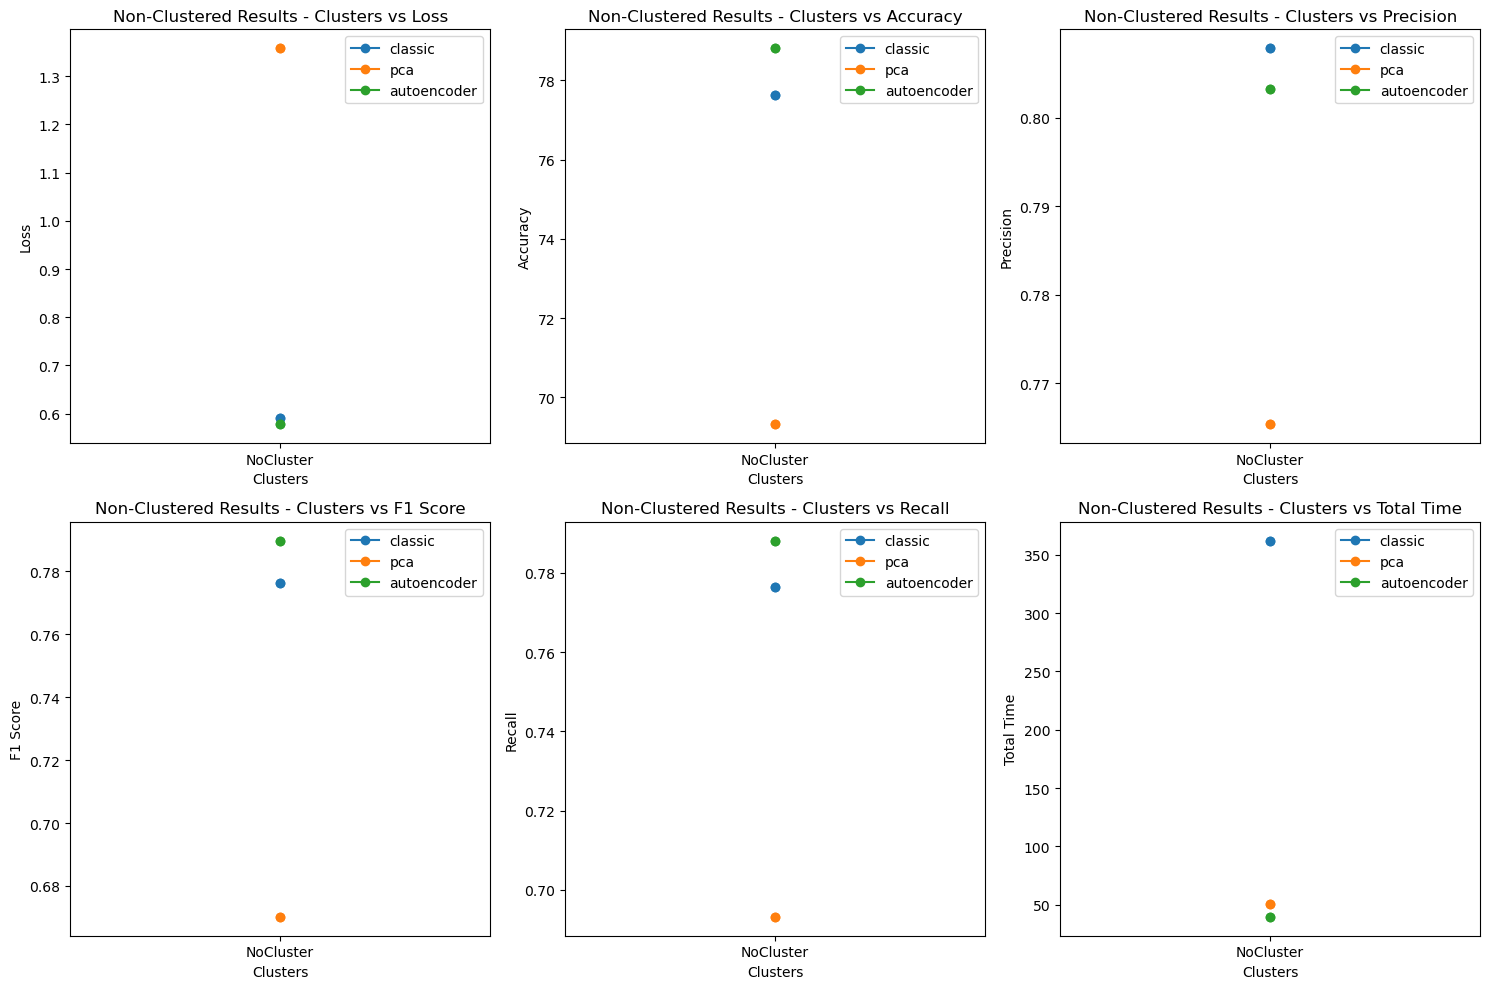


Clustered Results:
classic:
  Final Loss: {2: 0.7655611450195312, 4: 0.5893617309570313, 6: 0.5532511474609375, 8: 0.4679892852783203, 10: 0.44653302001953127}
  Final Accuracy: {2: 75.53, 4: 79.78, 6: 81.15, 8: 84.22, 10: 84.92}
  Final Precision: {2: 0.8044749566451304, 4: 0.8235380469375488, 6: 0.8343346259558991, 8: 0.8521863748748937, 10: 0.8559927663745027}
  Final F1 Score: {2: 0.7348586660906824, 4: 0.7979056421100259, 6: 0.813191862220464, 8: 0.8422778935600637, 10: 0.850218341965251}
  Final Recall: {2: 0.7553, 4: 0.7978, 6: 0.8115, 8: 0.8422000000000001, 10: 0.8492000000000001}
  Total Time: {2: 605.0644681453705, 4: 1145.3441989421844, 6: 1469.612596988678, 8: 2526.328642129898, 10: 2620.3582870960236}
pca:
  Final Loss: {2: 1.2901700927734374, 4: 1.1797845703125, 6: 1.118031591796875, 8: 1.0492071411132813, 10: 0.9954410034179687}
  Final Accuracy: {2: 57.6, 4: 65.69, 6: 65.42, 8: 68.83, 10: 72.81}
  Final Precision: {2: 0.7395037331718494, 4: 0.7365811552321778, 6: 0.753

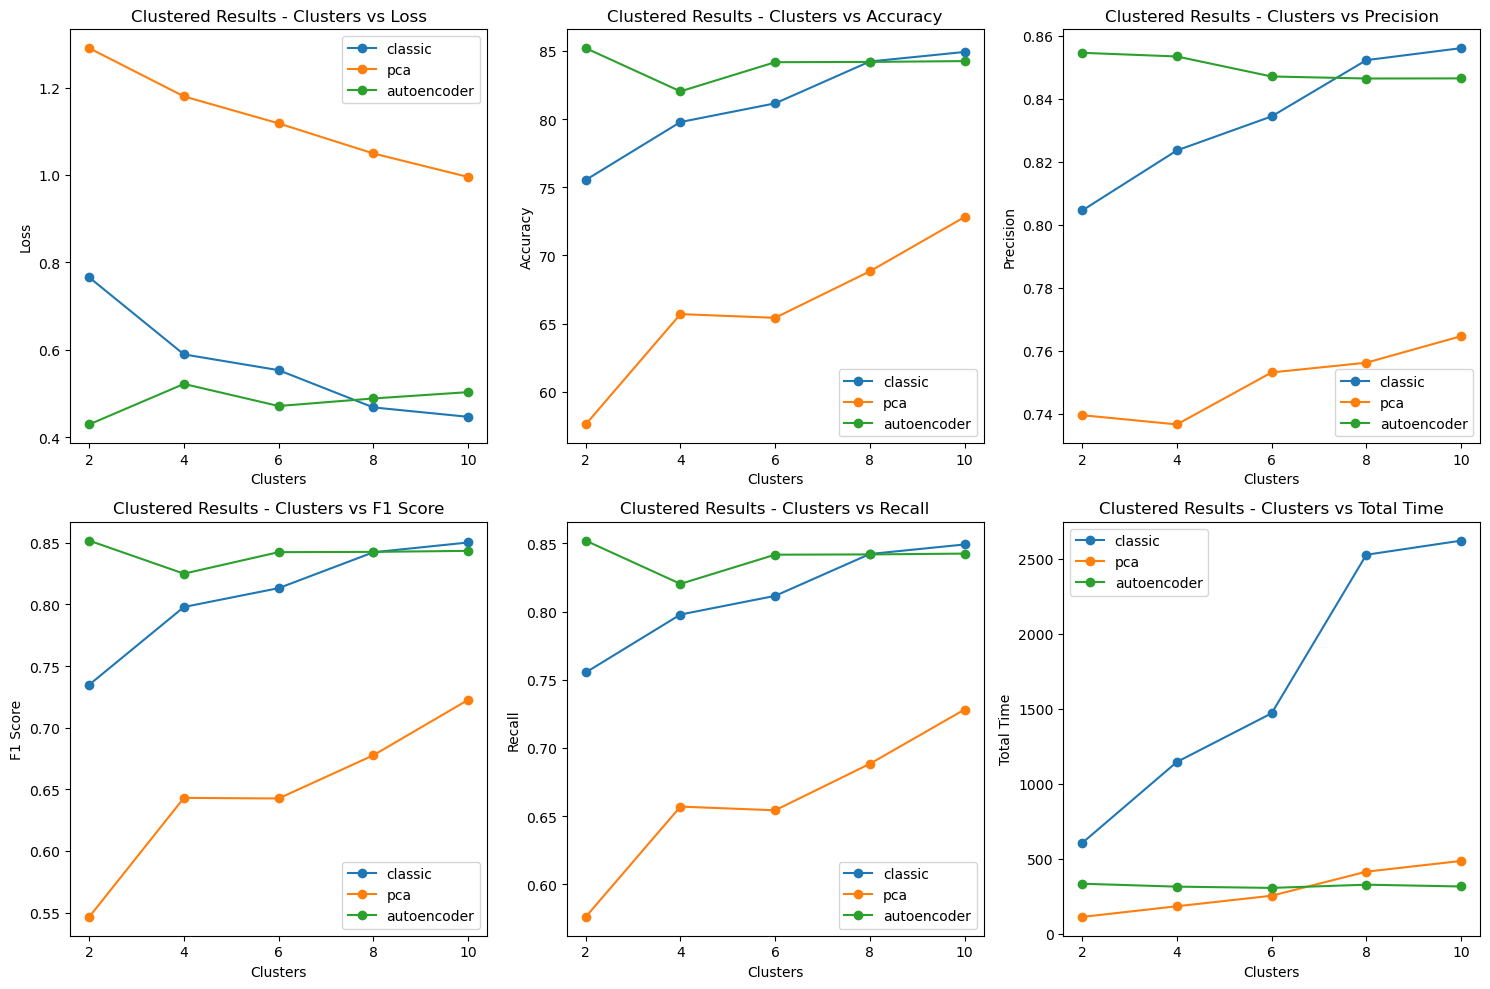

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#TODO: we have to multiply time by 8 first

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
